In [1]:
import pandas as pd
import numpy as np
import oracledb
from sqlalchemy import create_engine
import os
import glob
pd.set_option('display.max_columns',100)
import time
import seaborn as sns
import matplotlib.pyplot as plt

- Bad debt: Accounts with >=30 days DPD

# A. Query Data

In [2]:
# credentials
username = os.environ['DBA_USR']
password = os.environ['DBA_PW']
host = '10.220.50.121'
port = '1661'
service_name = 'ANALYTIC'

In [3]:
connection_string = f'oracle+oracledb://{username}:{password}@{host}:{port}/?service_name={service_name}'

In [4]:
# create engine
engine = create_engine(connection_string)

In [5]:
# create list of all dates
allDates = ['20241031','20240930','20240829','20240731','20240628','20240531',
            '20240430','20240328','20240229','20240131','20231229','20231130']
# no dpd for <202404

In [6]:
# open sql file 360
with open("CCPull_CUST360.sql", 'r') as file:
    query_360 = file.read()

# open sql PORTFOLIO
with open("CCPull_CUSTPORT.sql", 'r') as file:
    query_PORTFOLIO = file.read()

In [7]:
# print(query_template.format(dt='20241031'))

In [8]:
allMLs = []
for date in allDates:
    yearmonth = date[2:6]
    if int(date) > 20240329:
        try:
            # print in case of errors
            print(f'Running {date}')

            # open and read the file as a single buffer
            sqlQuery = query_360.format(dt=date)

            # run query and store data in df
            print('SQL run')
            with engine.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'{date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)

            time.sleep(5)
    else:
        try:
            # print in case of errors
            print(f'Running {date}')

            # open and read the file as a single buffer
            sqlQuery = query_PORTFOLIO.format(dt=date, ym=yearmonth)

            # run query and store data in df
            print('SQL run')
            with engine.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'{date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)

            time.sleep(5)

Running 20241031
SQL run
20241031 queried successfully
Running 20240930
SQL run
20240930 queried successfully
Running 20240829
SQL run
20240829 queried successfully
Running 20240731
SQL run
20240731 queried successfully
Running 20240628
SQL run
20240628 queried successfully
Running 20240531
SQL run
20240531 queried successfully
Running 20240430
SQL run
20240430 queried successfully
Running 20240328
SQL run
20240328 queried successfully
Running 20240229
SQL run
20240229 queried successfully
Running 20240131
SQL run
20240131 queried successfully
Running 20231229
SQL run
20231229 queried successfully
Running 20231130
SQL run
20231130 queried successfully


In [25]:
allMLs[7].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182350 entries, 0 to 182349
Data columns (total 79 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   BASE_DT           182350 non-null  object        
 1   AGREE_ID          182350 non-null  object        
 2   GCIF_NO           182350 non-null  object        
 3   CIF_NO            182350 non-null  object        
 4   NOTE_NO           182350 non-null  object        
 5   PRD_TP            182350 non-null  object        
 6   PRD_NM            182350 non-null  object        
 7   PRD_SEGMENT       182350 non-null  object        
 8   ORG_LMT_AMT       182350 non-null  float64       
 9   CURR_LMT_AMT      182350 non-null  float64       
 10  BAL               182350 non-null  float64       
 11  ORIG_INT_RT       182350 non-null  float64       
 12  CURR_INT_RT       182350 non-null  float64       
 13  OTH_CURR_INT_RT   182350 non-null  float64       
 14  CLCT

# B. EDA

In [26]:
# concat all MLs into one
MLs = pd.concat(allMLs, ignore_index=True)

In [27]:
MLs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177450 entries, 0 to 2177449
Data columns (total 79 columns):
 #   Column            Dtype         
---  ------            -----         
 0   BASE_DT           object        
 1   AGREE_ID          object        
 2   GCIF_NO           object        
 3   CIF_NO            object        
 4   NOTE_NO           object        
 5   PRD_TP            object        
 6   PRD_NM            object        
 7   PRD_SEGMENT       object        
 8   ORG_LMT_AMT       float64       
 9   CURR_LMT_AMT      float64       
 10  BAL               float64       
 11  ORIG_INT_RT       float64       
 12  CURR_INT_RT       float64       
 13  OTH_CURR_INT_RT   float64       
 14  CLCT_RTNG_FCL     object        
 15  ALLOW_PCT         float64       
 16  ALLOW_PCT_ADD     float64       
 17  RESTRUCT_CD       object        
 18  PASTDUE_SINCE_DT  object        
 19  PASTDUE_DAYS      int64         
 20  WRITE_OFF_AMT     float64       
 21  WRITE_OF

In [28]:
MLs.columns

Index(['BASE_DT', 'AGREE_ID', 'GCIF_NO', 'CIF_NO', 'NOTE_NO', 'PRD_TP',
       'PRD_NM', 'PRD_SEGMENT', 'ORG_LMT_AMT', 'CURR_LMT_AMT', 'BAL',
       'ORIG_INT_RT', 'CURR_INT_RT', 'OTH_CURR_INT_RT', 'CLCT_RTNG_FCL',
       'ALLOW_PCT', 'ALLOW_PCT_ADD', 'RESTRUCT_CD', 'PASTDUE_SINCE_DT',
       'PASTDUE_DAYS', 'WRITE_OFF_AMT', 'WRITE_OFF_DT', 'WRITE_OFF_YN',
       'CC_STATUS', 'GCIF_NO', 'SEGMENT', 'CUST_NM', 'OPEN_DATE',
       'LAST_ACTIVE_DATE', 'CUST_TP', 'GENDER_CD', 'AGE', 'SAGA_FLAG',
       'EMPLOYMENT_TYPE', 'CA_BAL', 'CA_AVG', 'SA_BAL', 'SA_AVG', 'TD_NOA',
       'TD_BAL', 'TD_AVG', 'SY_FUNDING_BAL', 'SY_FUNDING_AVG', 'FUNDING_NOA',
       'FUNDING_BAL', 'FUNDING_AVG', 'NOA_DORMANT', 'CC_PLAFOND', 'CC_BAL',
       'PL_PLAFOND', 'PLOAN_BAL', 'TR_PLAFOND', 'TR_BAL', 'PB_PLAFOND',
       'PB_BAL', 'PRK_PLAFOND', 'PRK_BAL', 'PPB_PLAFOND', 'PPB_BAL',
       'BG_PLAFOND', 'BG_BAL', 'LC_PLAFOND', 'LC_BAL', 'SY_LOAN_PLAFOND',
       'SY_LOAN_BAL', 'KPR_PLAFOND', 'KPR_BAL', 'KPM_PLAFON

In [29]:
MLs = MLs.loc[:, ~MLs.columns.duplicated()].copy()

In [30]:
MLs['SAGA_FLAG'].value_counts()

SAGA_FLAG
NON-SAGA    1209373
SAGA         941609
Name: count, dtype: int64

## 1. SAGA total monthly bad debt

In [31]:
# SAGA delinquency count
SAGADeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['SAGA_FLAG']=='SAGA')][['BASE_DT']].value_counts()

# Convert to DataFrame
SAGADeliCount = SAGADeliCount.reset_index()
SAGADeliCount.columns = ['BASE_DT', 'ACCT_COUNT']
SAGADeliCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliCount.sort_values(by=['BASE_DT'], inplace=True)
SAGADeliCount['BASE_DT'] = SAGADeliCount['BASE_DT'].str[2:6]

In [32]:
# Total delinquency count
TotalDeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT')][['BASE_DT']].value_counts()

# Convert to DataFrame
TotalDeliCount = TotalDeliCount.reset_index()
TotalDeliCount.columns = ['BASE_DT', 'ACCT_COUNT']
TotalDeliCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliCount.sort_values(by=['BASE_DT'], inplace=True)
TotalDeliCount['BASE_DT'] = TotalDeliCount['BASE_DT'].str[2:6]

In [33]:
AllDeliCount = pd.concat([SAGADeliCount, TotalDeliCount], ignore_index=True)

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

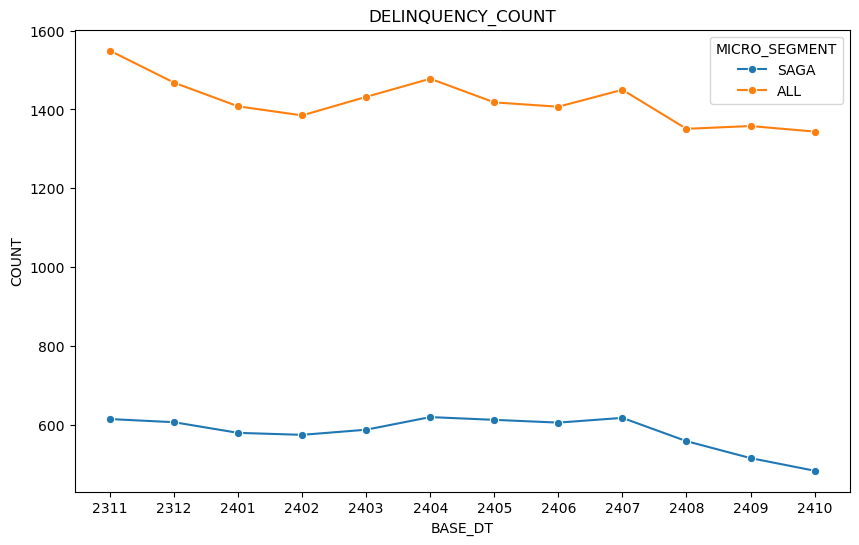

In [34]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

## 2. SAGA monthly new bad debt

In [57]:
# set dataframe for dpd change calculation
DPDMonthly = MLs[['BASE_DT', 'AGREE_ID', 'PASTDUE_DAYS']].reset_index()

In [58]:
# checking pastdue values
DPDMonthly['PASTDUE_DAYS'].value_counts()

PASTDUE_DAYS
0      2108866
1        40809
30       10727
60        6189
90        4365
120       3585
150       2842
210         62
180          5
Name: count, dtype: int64

In [59]:
# create pivot table
DPDMonthlyPivot = DPDMonthly.pivot(index='AGREE_ID',
                                   columns='BASE_DT',
                                   values='PASTDUE_DAYS')

In [60]:
# flaten columns
DPDMonthlyPivot = DPDMonthlyPivot.rename_axis(index=None, columns=None).reset_index()

In [61]:
DPDMonthlyPivot.columns

Index(['index', '20231130', '20231229', '20240131', '20240229', '20240328',
       '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
       '20241031'],
      dtype='object')

In [62]:
# rename columns
DPDMonthlyPivot.columns = [
    'AGREE_ID', '20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

In [65]:
# fillna with 0
DPDMonthlyPivot.fillna(0, inplace=True)

# date for loop
dateCol = ['20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']
# calculate dpd change for all dates
for i in range(1,len(dateCol)):
    prevDate = dateCol[i-1]
    date = dateCol[i]
    DPDMonthlyPivot[f'DELINQUENT_{date}'] = DPDMonthlyPivot.apply(
        lambda x: 1 if x[prevDate]<30 and x[date]>=30 else 0,
        axis=1)

In [67]:
# test value
DPDMonthlyPivot[['DELINQUENT_20240430']].value_counts()

DELINQUENT_20240430
0                      255118
1                         579
Name: count, dtype: int64

In [82]:
# take only used cols
usedCols = [list(DPDMonthlyPivot.columns)[0]]+list(DPDMonthlyPivot.columns)[13:]
DPDMonthlyPivot = DPDMonthlyPivot[usedCols]

In [83]:
# longify
DPDMonthlyLong = pd.wide_to_long(DPDMonthlyPivot,
                                 stubnames='DELINQUENT',
                                 i = 'AGREE_ID',
                                 j = 'BASE_DT',
                                 sep = '_')

In [88]:
# reset index and change base_dt type to string
DPDMonthlyLong = DPDMonthlyLong.reset_index()
DPDMonthlyLong['BASE_DT'] = DPDMonthlyLong['BASE_DT'].astype(str)

In [89]:
DPDMonthlyLong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812667 entries, 0 to 2812666
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   index       int64 
 1   AGREE_ID    object
 2   BASE_DT     object
 3   DELINQUENT  int64 
dtypes: int64(2), object(2)
memory usage: 85.8+ MB


In [ ]:
# merge delinquency flag to original data
MLs = MLs.merge(DPDMonthlyLong[['AGREE_ID', 'BASE_DT', 'DELINQUENT']], on=['AGREE_ID', 'BASE_DT'], how='left')

In [91]:
MLs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177450 entries, 0 to 2177449
Data columns (total 79 columns):
 #   Column            Dtype         
---  ------            -----         
 0   BASE_DT           object        
 1   AGREE_ID          object        
 2   GCIF_NO           object        
 3   CIF_NO            object        
 4   NOTE_NO           object        
 5   PRD_TP            object        
 6   PRD_NM            object        
 7   PRD_SEGMENT       object        
 8   ORG_LMT_AMT       float64       
 9   CURR_LMT_AMT      float64       
 10  BAL               float64       
 11  ORIG_INT_RT       float64       
 12  CURR_INT_RT       float64       
 13  OTH_CURR_INT_RT   float64       
 14  CLCT_RTNG_FCL     object        
 15  ALLOW_PCT         float64       
 16  ALLOW_PCT_ADD     float64       
 17  RESTRUCT_CD       object        
 18  PASTDUE_SINCE_DT  object        
 19  PASTDUE_DAYS      int64         
 20  WRITE_OFF_AMT     float64       
 21  WRITE_OF

1. Hitung total bad debt SAGA all month
2. Bandingkan bad debt SAGA vs all other CC
2. Bandingkan 